In [1]:
import os

folder = "models"
mode_version = "spec_arr_v1"
mode_version = os.path.join(folder, mode_version)

print(mode_version)

models/spec_arr_v1


In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

#from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [5]:
# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [6]:
X_all = np.load('../../data/spec_array_x.npy', allow_pickle= True)
Y_all =  np.load('../../data/spec_array_y.npy', allow_pickle= True)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 128, 300, 1)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2> Train and Save Model</h2>

In [8]:
def build_current_model():
    inp = Input(shape=(128,300,1))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [9]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 300, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 150, 56)       2800      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 150, 56)       224       
_________________________________________________________________
activation (Activation)      (None, 64, 150, 56)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 75, 56)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 75, 56)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 38, 72)        100872

In [10]:
from sklearn.model_selection import StratifiedKFold
n_split=10
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
count = 1

for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 245, stratify=y_train)
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
    
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_data= (x_val, y_val),
              verbose=2,
              callbacks=my_callbacks)
    
    
    file_name = mode_version +'_iter_' +str(count)

    #Store History
    hist_df = pd.DataFrame(history.history) 
    hist_json_file = file_name + '.json'
    
    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)
    
    model_file = file_name + '.model'
    print(model_file)
    #Save Model
    cv_model.save(model_file) #Save the model
    
    count+=1



    
    
    

Original trainingset shape [('T.perforatus', 290), ('R.muscatellum', 1198), ('E.bottae', 90), ('R.aegyptius', 87), ('P.kuhli', 216), ('R.nasutus', 193), ('M.emarginatus', 80), ('A.tridens', 18)]
Resampled training set shape [('T.perforatus', 1198), ('R.muscatellum', 1198), ('E.bottae', 1198), ('R.aegyptius', 1198), ('P.kuhli', 1198), ('R.nasutus', 1198), ('M.emarginatus', 1198), ('A.tridens', 1198)]
After OverSampling
X_train: shape=  (9584, 128, 300, 1)
Y_train: shape=  (9584, 8)
Epoch 1/100
1198/1198 - 6s - loss: 1.5126 - accuracy: 0.4256 - val_loss: 5.9741 - val_accuracy: 0.2463
Epoch 2/100
1198/1198 - 5s - loss: 0.8186 - accuracy: 0.7075 - val_loss: 0.8238 - val_accuracy: 0.6893
Epoch 3/100
1198/1198 - 5s - loss: 0.4470 - accuracy: 0.8471 - val_loss: 1.5960 - val_accuracy: 0.6195
Epoch 4/100
1198/1198 - 6s - loss: 0.3079 - accuracy: 0.8963 - val_loss: 0.8207 - val_accuracy: 0.7353
Epoch 5/100
1198/1198 - 6s - loss: 0.2335 - accuracy: 0.9250 - val_loss: 1.3729 - val_accuracy: 0.6636

Epoch 76/100
1198/1198 - 6s - loss: 0.0334 - accuracy: 0.9883 - val_loss: 0.3358 - val_accuracy: 0.9320
Epoch 77/100
1198/1198 - 6s - loss: 0.0287 - accuracy: 0.9917 - val_loss: 0.3653 - val_accuracy: 0.9283
Epoch 78/100
1198/1198 - 6s - loss: 0.0275 - accuracy: 0.9910 - val_loss: 0.1143 - val_accuracy: 0.9724
Epoch 79/100
1198/1198 - 6s - loss: 0.0367 - accuracy: 0.9874 - val_loss: 0.0935 - val_accuracy: 0.9798
Epoch 80/100
1198/1198 - 6s - loss: 0.0294 - accuracy: 0.9902 - val_loss: 0.0735 - val_accuracy: 0.9706
Epoch 81/100
1198/1198 - 6s - loss: 0.0339 - accuracy: 0.9896 - val_loss: 0.1181 - val_accuracy: 0.9559
Epoch 82/100
1198/1198 - 6s - loss: 0.0301 - accuracy: 0.9910 - val_loss: 0.2372 - val_accuracy: 0.9449
Epoch 83/100
1198/1198 - 6s - loss: 0.0268 - accuracy: 0.9919 - val_loss: 0.2778 - val_accuracy: 0.9430
Epoch 84/100
1198/1198 - 6s - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.0746 - val_accuracy: 0.9798
Epoch 85/100
1198/1198 - 6s - loss: 0.0336 - accuracy: 0.9894 - 

Epoch 45/100
1198/1198 - 6s - loss: 0.0523 - accuracy: 0.9843 - val_loss: 0.2089 - val_accuracy: 0.9338
Epoch 46/100
1198/1198 - 6s - loss: 0.0434 - accuracy: 0.9864 - val_loss: 0.1304 - val_accuracy: 0.9577
Epoch 47/100
1198/1198 - 6s - loss: 0.0405 - accuracy: 0.9867 - val_loss: 0.2296 - val_accuracy: 0.9412
Epoch 48/100
1198/1198 - 6s - loss: 0.0479 - accuracy: 0.9862 - val_loss: 0.1523 - val_accuracy: 0.9577
Epoch 49/100
1198/1198 - 6s - loss: 0.0347 - accuracy: 0.9885 - val_loss: 0.1060 - val_accuracy: 0.9761
Epoch 50/100
1198/1198 - 6s - loss: 0.0339 - accuracy: 0.9898 - val_loss: 0.3160 - val_accuracy: 0.9191
Epoch 51/100
1198/1198 - 6s - loss: 0.0386 - accuracy: 0.9874 - val_loss: 0.1275 - val_accuracy: 0.9669
Epoch 52/100
1198/1198 - 6s - loss: 0.0480 - accuracy: 0.9842 - val_loss: 0.4459 - val_accuracy: 0.8842
Epoch 53/100
1198/1198 - 6s - loss: 0.0339 - accuracy: 0.9897 - val_loss: 0.2784 - val_accuracy: 0.9173
Epoch 54/100
1198/1198 - 6s - loss: 0.0466 - accuracy: 0.9858 - 

Epoch 26/100
1198/1198 - 6s - loss: 0.0603 - accuracy: 0.9832 - val_loss: 0.2699 - val_accuracy: 0.9228
Epoch 27/100
1198/1198 - 6s - loss: 0.0652 - accuracy: 0.9802 - val_loss: 0.2968 - val_accuracy: 0.9338
Epoch 28/100
1198/1198 - 6s - loss: 0.0620 - accuracy: 0.9818 - val_loss: 0.3101 - val_accuracy: 0.9191
Epoch 29/100
1198/1198 - 6s - loss: 0.0554 - accuracy: 0.9821 - val_loss: 0.2251 - val_accuracy: 0.9412
Epoch 30/100
1198/1198 - 6s - loss: 0.0490 - accuracy: 0.9840 - val_loss: 0.4844 - val_accuracy: 0.8695
Epoch 31/100
1198/1198 - 6s - loss: 0.0635 - accuracy: 0.9803 - val_loss: 0.2102 - val_accuracy: 0.9338
Epoch 32/100
1198/1198 - 6s - loss: 0.0471 - accuracy: 0.9839 - val_loss: 0.3555 - val_accuracy: 0.9026
Epoch 33/100
1198/1198 - 6s - loss: 0.0494 - accuracy: 0.9848 - val_loss: 0.3811 - val_accuracy: 0.8989
Epoch 34/100
1198/1198 - 6s - loss: 0.0565 - accuracy: 0.9832 - val_loss: 0.2058 - val_accuracy: 0.9412
Epoch 35/100
1198/1198 - 6s - loss: 0.0533 - accuracy: 0.9831 - 

Epoch 4/100
1198/1198 - 6s - loss: 0.3084 - accuracy: 0.8980 - val_loss: 0.8372 - val_accuracy: 0.7592
Epoch 5/100
1198/1198 - 6s - loss: 0.2408 - accuracy: 0.9222 - val_loss: 0.5391 - val_accuracy: 0.8640
Epoch 6/100
1198/1198 - 6s - loss: 0.1883 - accuracy: 0.9358 - val_loss: 0.4367 - val_accuracy: 0.8438
Epoch 7/100
1198/1198 - 6s - loss: 0.1720 - accuracy: 0.9425 - val_loss: 0.5446 - val_accuracy: 0.7941
Epoch 8/100
1198/1198 - 6s - loss: 0.1562 - accuracy: 0.9517 - val_loss: 0.5562 - val_accuracy: 0.8438
Epoch 9/100
1198/1198 - 6s - loss: 0.1377 - accuracy: 0.9581 - val_loss: 0.5889 - val_accuracy: 0.8033
Epoch 10/100
1198/1198 - 6s - loss: 0.1292 - accuracy: 0.9594 - val_loss: 0.5174 - val_accuracy: 0.8438
Epoch 11/100
1198/1198 - 6s - loss: 0.1160 - accuracy: 0.9624 - val_loss: 0.4958 - val_accuracy: 0.8511
Epoch 12/100
1198/1198 - 6s - loss: 0.1180 - accuracy: 0.9615 - val_loss: 0.2390 - val_accuracy: 0.9320
Epoch 13/100
1198/1198 - 6s - loss: 0.1027 - accuracy: 0.9680 - val_lo

Epoch 9/100
1198/1198 - 6s - loss: 0.1489 - accuracy: 0.9520 - val_loss: 1.5118 - val_accuracy: 0.7077
Epoch 10/100
1198/1198 - 6s - loss: 0.1371 - accuracy: 0.9543 - val_loss: 1.1733 - val_accuracy: 0.7353
Epoch 11/100
1198/1198 - 6s - loss: 0.1265 - accuracy: 0.9578 - val_loss: 0.2939 - val_accuracy: 0.9081
Epoch 12/100
1198/1198 - 6s - loss: 0.1228 - accuracy: 0.9589 - val_loss: 1.0031 - val_accuracy: 0.7684
Epoch 13/100
1198/1198 - 6s - loss: 0.1171 - accuracy: 0.9635 - val_loss: 0.7033 - val_accuracy: 0.8364
Epoch 14/100
1198/1198 - 6s - loss: 0.1043 - accuracy: 0.9658 - val_loss: 0.4718 - val_accuracy: 0.8676
Epoch 15/100
1198/1198 - 6s - loss: 0.1071 - accuracy: 0.9667 - val_loss: 1.6708 - val_accuracy: 0.6103
Epoch 16/100
1198/1198 - 6s - loss: 0.0986 - accuracy: 0.9677 - val_loss: 0.3352 - val_accuracy: 0.8989
Epoch 17/100
1198/1198 - 6s - loss: 0.1043 - accuracy: 0.9678 - val_loss: 0.8587 - val_accuracy: 0.7886
Epoch 18/100
1198/1198 - 6s - loss: 0.0927 - accuracy: 0.9719 - v

Epoch 88/100
1198/1198 - 6s - loss: 0.0372 - accuracy: 0.9874 - val_loss: 0.0641 - val_accuracy: 0.9853
Epoch 89/100
1198/1198 - 6s - loss: 0.0243 - accuracy: 0.9919 - val_loss: 0.0973 - val_accuracy: 0.9688
Epoch 90/100
1198/1198 - 6s - loss: 0.0269 - accuracy: 0.9912 - val_loss: 0.0788 - val_accuracy: 0.9798
Epoch 91/100
1198/1198 - 6s - loss: 0.0348 - accuracy: 0.9899 - val_loss: 0.1007 - val_accuracy: 0.9798
Epoch 92/100
1198/1198 - 6s - loss: 0.0343 - accuracy: 0.9907 - val_loss: 0.1364 - val_accuracy: 0.9688
Epoch 93/100
1198/1198 - 6s - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.1078 - val_accuracy: 0.9724
Epoch 94/100
1198/1198 - 6s - loss: 0.0336 - accuracy: 0.9900 - val_loss: 0.0923 - val_accuracy: 0.9835
Epoch 95/100
1198/1198 - 6s - loss: 0.0244 - accuracy: 0.9905 - val_loss: 0.1487 - val_accuracy: 0.9522
Epoch 96/100
1198/1198 - 6s - loss: 0.0212 - accuracy: 0.9943 - val_loss: 0.0922 - val_accuracy: 0.9798
Epoch 97/100
1198/1198 - 6s - loss: 0.0302 - accuracy: 0.9904 - 

Epoch 1/100
1199/1199 - 6s - loss: 1.4701 - accuracy: 0.4450 - val_loss: 2.3794 - val_accuracy: 0.3162
Epoch 2/100
1199/1199 - 6s - loss: 0.8798 - accuracy: 0.6834 - val_loss: 1.4590 - val_accuracy: 0.5588
Epoch 3/100
1199/1199 - 6s - loss: 0.5126 - accuracy: 0.8252 - val_loss: 0.6679 - val_accuracy: 0.7426
Epoch 4/100
1199/1199 - 6s - loss: 0.3510 - accuracy: 0.8812 - val_loss: 0.4406 - val_accuracy: 0.8438
Epoch 5/100
1199/1199 - 6s - loss: 0.2499 - accuracy: 0.9176 - val_loss: 0.3356 - val_accuracy: 0.8787
Epoch 6/100
1199/1199 - 6s - loss: 0.2162 - accuracy: 0.9280 - val_loss: 0.4806 - val_accuracy: 0.8529
Epoch 7/100
1199/1199 - 6s - loss: 0.1953 - accuracy: 0.9392 - val_loss: 0.5657 - val_accuracy: 0.8419
Epoch 8/100
1199/1199 - 6s - loss: 0.1583 - accuracy: 0.9476 - val_loss: 0.4961 - val_accuracy: 0.8493
Epoch 9/100
1199/1199 - 6s - loss: 0.1560 - accuracy: 0.9514 - val_loss: 0.4230 - val_accuracy: 0.8842
Epoch 10/100
1199/1199 - 6s - loss: 0.1357 - accuracy: 0.9575 - val_loss:

Resampled training set shape [('R.muscatellum', 1199), ('E.bottae', 1199), ('R.nasutus', 1199), ('R.aegyptius', 1199), ('T.perforatus', 1199), ('P.kuhli', 1199), ('A.tridens', 1199), ('M.emarginatus', 1199)]
After OverSampling
X_train: shape=  (9592, 128, 300, 1)
Y_train: shape=  (9592, 8)
Epoch 1/100
1199/1199 - 6s - loss: 1.4864 - accuracy: 0.4434 - val_loss: 1.6493 - val_accuracy: 0.5110
Epoch 2/100
1199/1199 - 6s - loss: 0.8889 - accuracy: 0.6707 - val_loss: 2.7977 - val_accuracy: 0.2077
Epoch 3/100
1199/1199 - 6s - loss: 0.5238 - accuracy: 0.8151 - val_loss: 0.6352 - val_accuracy: 0.7739
Epoch 4/100
1199/1199 - 6s - loss: 0.3633 - accuracy: 0.8766 - val_loss: 0.7088 - val_accuracy: 0.7555
Epoch 5/100
1199/1199 - 6s - loss: 0.2725 - accuracy: 0.9100 - val_loss: 1.5126 - val_accuracy: 0.6029
Epoch 6/100
1199/1199 - 6s - loss: 0.2174 - accuracy: 0.9288 - val_loss: 0.3680 - val_accuracy: 0.8713
Epoch 7/100
1199/1199 - 6s - loss: 0.1863 - accuracy: 0.9428 - val_loss: 0.3367 - val_accur

Epoch 6/100
1199/1199 - 6s - loss: 0.2020 - accuracy: 0.9349 - val_loss: 0.5943 - val_accuracy: 0.8199
Epoch 7/100
1199/1199 - 6s - loss: 0.1837 - accuracy: 0.9402 - val_loss: 0.5552 - val_accuracy: 0.8364
Epoch 8/100
1199/1199 - 6s - loss: 0.1765 - accuracy: 0.9422 - val_loss: 0.5221 - val_accuracy: 0.8493
Epoch 9/100
1199/1199 - 6s - loss: 0.1490 - accuracy: 0.9531 - val_loss: 0.3893 - val_accuracy: 0.8787
Epoch 10/100
1199/1199 - 6s - loss: 0.1387 - accuracy: 0.9536 - val_loss: 0.4232 - val_accuracy: 0.8676
Epoch 11/100
1199/1199 - 6s - loss: 0.1272 - accuracy: 0.9594 - val_loss: 0.2675 - val_accuracy: 0.9118
Epoch 12/100
1199/1199 - 6s - loss: 0.1153 - accuracy: 0.9625 - val_loss: 0.5871 - val_accuracy: 0.8511
Epoch 13/100
1199/1199 - 6s - loss: 0.1116 - accuracy: 0.9643 - val_loss: 0.6004 - val_accuracy: 0.8438
Epoch 14/100
1199/1199 - 6s - loss: 0.1121 - accuracy: 0.9658 - val_loss: 0.6569 - val_accuracy: 0.8327
Epoch 15/100
1199/1199 - 6s - loss: 0.0887 - accuracy: 0.9709 - val_

Epoch 19/100
1199/1199 - 6s - loss: 0.0750 - accuracy: 0.9780 - val_loss: 0.5540 - val_accuracy: 0.8621
Epoch 20/100
1199/1199 - 6s - loss: 0.0750 - accuracy: 0.9758 - val_loss: 0.3304 - val_accuracy: 0.9118
Epoch 21/100
1199/1199 - 6s - loss: 0.0748 - accuracy: 0.9760 - val_loss: 1.1553 - val_accuracy: 0.7371
Epoch 22/100
1199/1199 - 6s - loss: 0.0727 - accuracy: 0.9790 - val_loss: 0.4979 - val_accuracy: 0.8548
Epoch 23/100
1199/1199 - 6s - loss: 0.0683 - accuracy: 0.9777 - val_loss: 0.5854 - val_accuracy: 0.8529
Epoch 24/100
1199/1199 - 6s - loss: 0.0719 - accuracy: 0.9773 - val_loss: 0.2382 - val_accuracy: 0.9338
Epoch 25/100
1199/1199 - 6s - loss: 0.0587 - accuracy: 0.9798 - val_loss: 0.5453 - val_accuracy: 0.8824
Epoch 26/100
1199/1199 - 6s - loss: 0.0641 - accuracy: 0.9815 - val_loss: 0.2328 - val_accuracy: 0.9449
Epoch 27/100
1199/1199 - 6s - loss: 0.0635 - accuracy: 0.9806 - val_loss: 0.3055 - val_accuracy: 0.9154
Epoch 28/100
1199/1199 - 6s - loss: 0.0571 - accuracy: 0.9815 - 

# Load and Evaluate

In [11]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

n_split=10
n_classes=8


In [12]:
all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()

all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()

all_df = list()

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
             
count = 1


for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    file_name = mode_version +'_iter_' +str(count)

    #Load History 
    hist_json_file = file_name + '.json'
    history_info = pd.read_json(hist_json_file)
    all_df.append(history_info)
    
   
    # Load Model
    model_file = file_name + '.model'
    cv_model = tf.keras.models.load_model(model_file) 
    
    count+=1

    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)

    
    
    

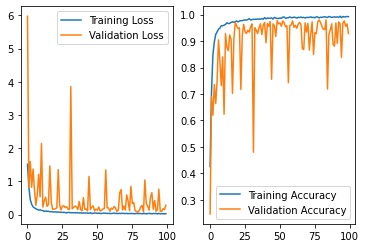

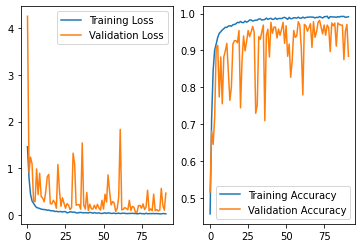

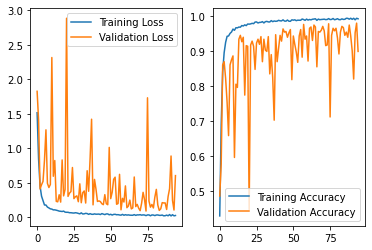

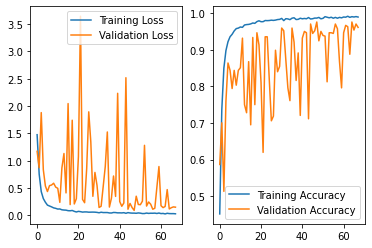

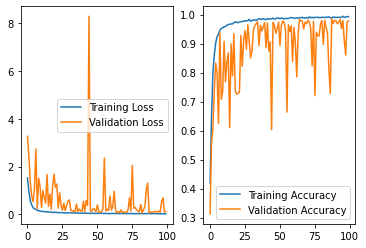

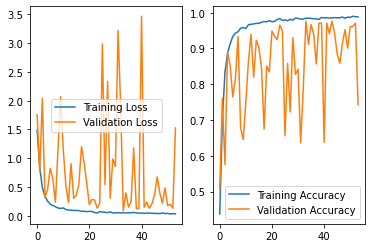

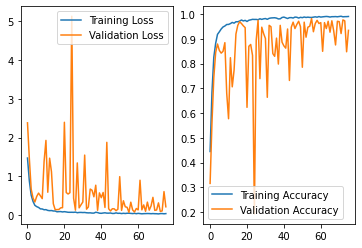

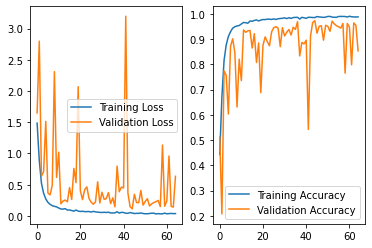

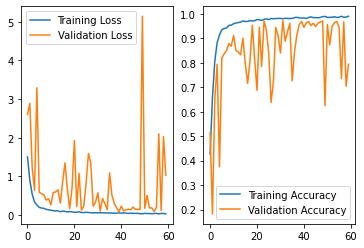

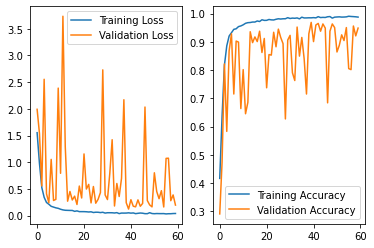

In [13]:
for df in all_df:
    _, axs = plt.subplots(ncols=2)

    sns.lineplot(data=df['loss'],ax=axs[0], label='Training Loss', legend='brief')
    sns.lineplot(data=df['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

    sns.lineplot(data=df['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
    sns.lineplot(data=df['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [14]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.94811355 0.92449634 0.96556077 0.9904846  0.9714012
 0.95375458 0.97046947]
precision sdev by class [0.         0.04544635 0.11603371 0.03451858 0.00961049 0.03031317
 0.07059157 0.02411542]
macro precision mean 0.9655350627792266
macro precision sdev 0.024087926185536596
recall mean [0.96666667 0.96025641 0.9280303  0.97655172 0.98438424 0.97777778
 0.95       0.9702439 ]
recall sdev [0.1        0.05261099 0.07911137 0.03961167 0.01447857 0.02456759
 0.05527708 0.03265561]
macro recall mean 0.9642388784836479
macro recall sdev 0.018562764638347166
f1 mean [0.98       0.95276548 0.92003394 0.96999166 0.98732557 0.97419363
 0.95091948 0.97011447]
f1 sdev [0.06       0.0338536  0.074483   0.02128134 0.00746385 0.02009548
 0.05612334 0.02435726]
macro f1 mean 0.9631680292249477
macro f1 sdev 0.0186626650717434
accuracy mean 0.9764790653670985
accuracy sdev 0.011882491634069776


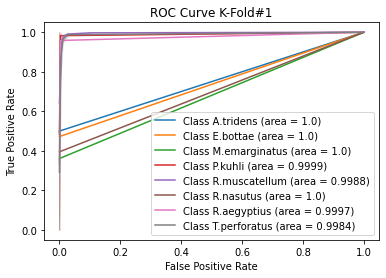

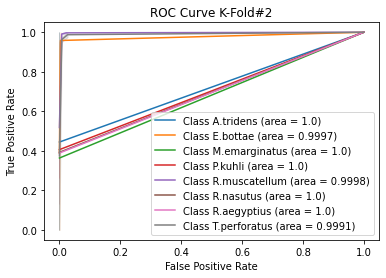

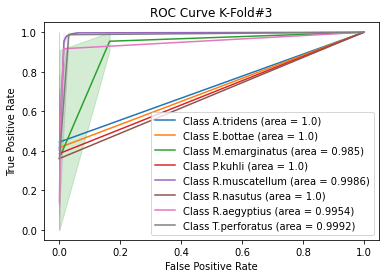

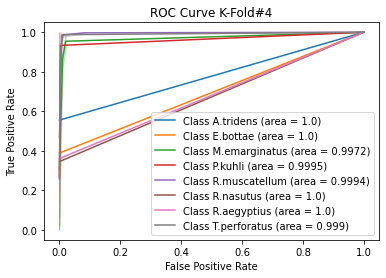

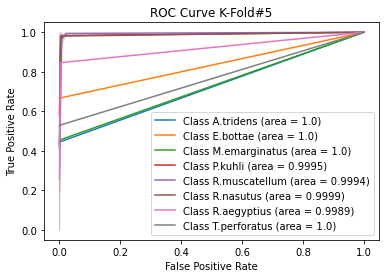

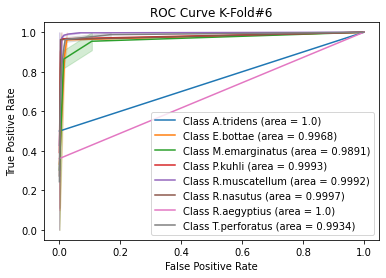

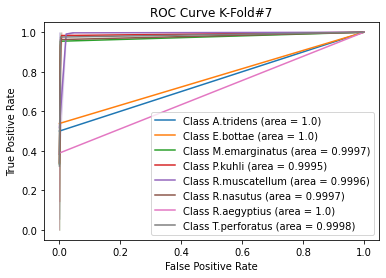

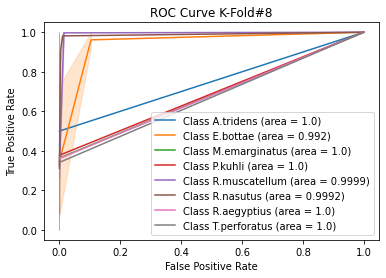

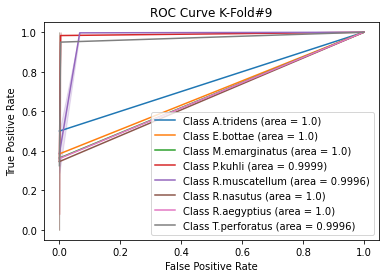

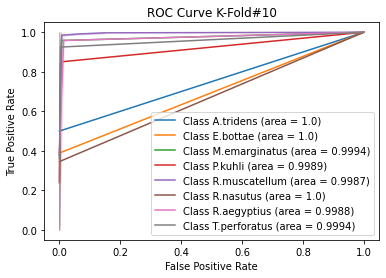

In [15]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [16]:
aucs = list()

for i in range(n_classes):
    aucs.append(list())


# Plot all K-Fold ROC curves

for i in range(n_split):
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        aucs[j].append(auc_val)
        
for i in range(n_classes):
    print("Sp: ", getSpecies(i))
    print("AUC Mean ", np.array(aucs[i]).mean())
    print("Std ", np.array(aucs[i]).std())

Sp:  A.tridens
AUC Mean  1.0
Std  0.0
Sp:  E.bottae
AUC Mean  0.9988533511391762
Std  0.002467755032761512
Sp:  M.emarginatus
AUC Mean  0.9970369877925259
Std  0.005147374039316118
Sp:  P.kuhli
AUC Mean  0.9996437794875798
Std  0.00035343466690986123
Sp:  R.muscatellum
AUC Mean  0.9992894756199862
Std  0.0004497039805758558
Sp:  R.nasutus
AUC Mean  0.9998513845252976
Std  0.0002442658958495113
Sp:  R.aegyptius
AUC Mean  0.9992896860725878
Std  0.0013652783639962038
Sp:  T.perforatus
AUC Mean  0.9988021879955573
Std  0.0018721203658531925


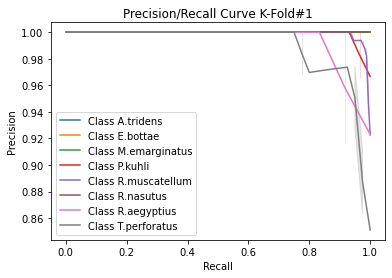

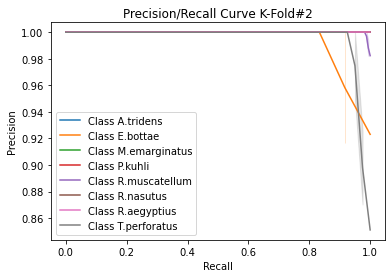

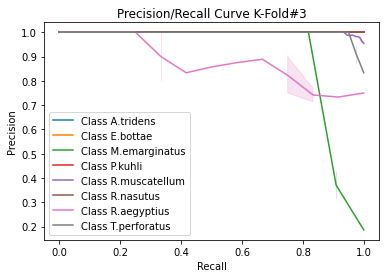

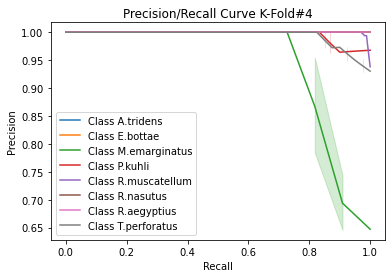

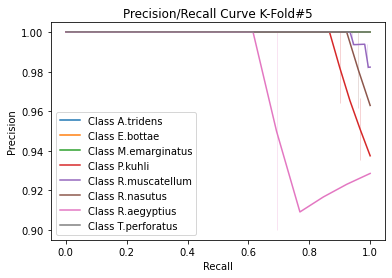

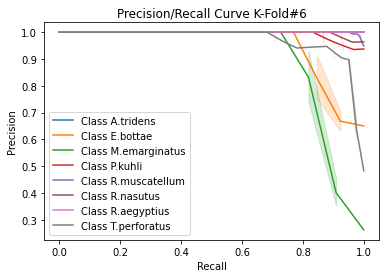

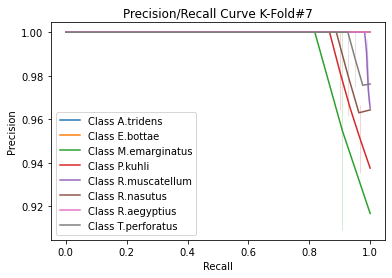

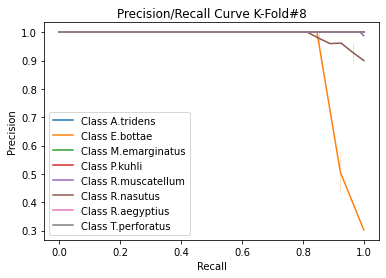

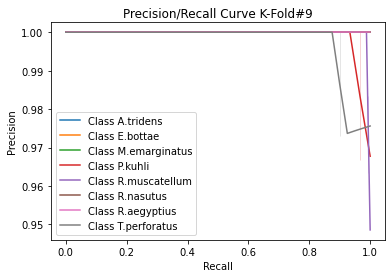

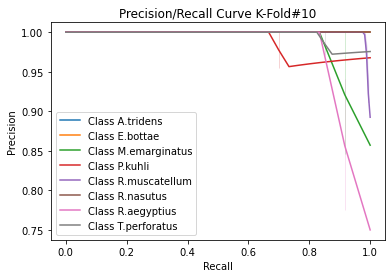

In [17]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  3   0   0   0   0   0   0   0]
 [  0  11   0   0   1   0   0   0]
 [  0   0  12   0   0   0   0   0]
 [  0   0   1  28   0   0   0   0]
 [  0   0   0   0 165   0   1   1]
 [  0   0   0   1   0  26   0   0]
 [  0   0   1   0   0   0  11   0]
 [  0   0   0   0   3   0   0  37]]


Confusion Matrix K-Fold #2

[[  3   0   0   0   0   0   0   0]
 [  0  11   0   0   1   0   0   0]
 [  0   0  11   0   0   0   0   0]
 [  0   0   0  30   0   0   0   0]
 [  0   0   1   0 166   0   0   0]
 [  0   0   0   0   0  27   0   0]
 [  0   0   0   0   0   0  12   0]
 [  0   0   0   0   2   0   0  38]]


Confusion Matrix K-Fold #3

[[  3   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0  10   0   0   0   1   0]
 [  0   0   0  30   0   0   0   0]
 [  0   0   4   1 158   0   2   2]
 [  0   1   0   1   0  25   0   0]
 [  0   0   1   0   1   0  10   0]
 [  0   0   1   0   0   0   0  39]]


Confusion Matrix K-Fold #4

[[  3   0   0   0   0   0   0   0]
 [  

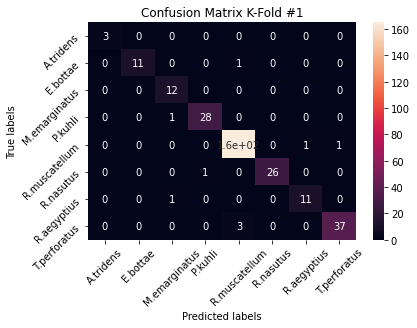

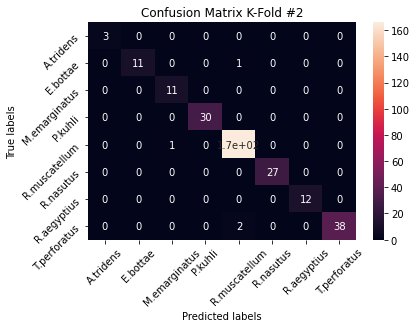

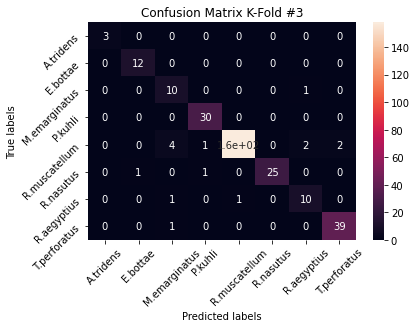

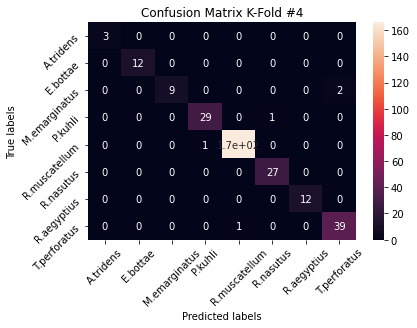

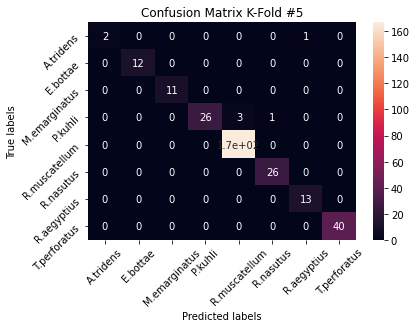

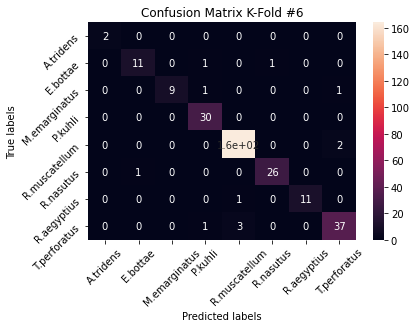

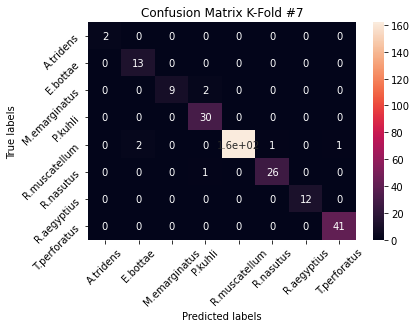

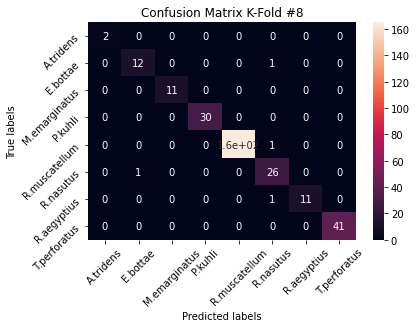

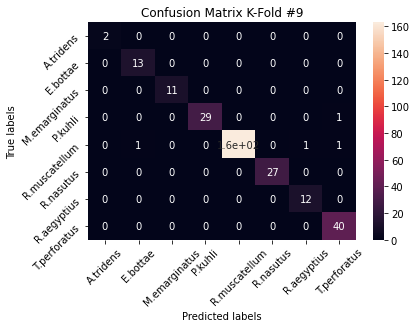

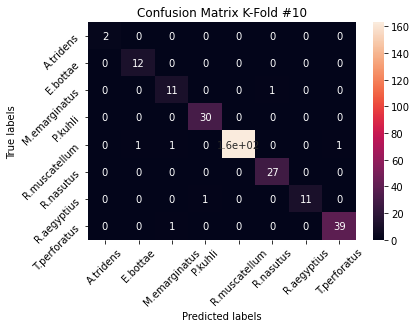

In [18]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  24    0    0    0    0    0    1    0]
 [   0  119    0    1    2    2    0    0]
 [   0    0  104    3    0    1    1    3]
 [   0    0    1  292    3    2    0    1]
 [   0    4    6    2 1639    2    4    8]
 [   0    3    0    3    0  263    0    0]
 [   0    0    2    1    2    1  115    0]
 [   0    0    2    1    9    0    0  391]]

average of all confuion matrices
 [[  2   0   0   0   0   0   0   0]
 [  0  11   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0]
 [  0   0   0  29   0   0   0   0]
 [  0   0   0   0 163   0   0   0]
 [  0   0   0   0   0  26   0   0]
 [  0   0   0   0   0   0  11   0]
 [  0   0   0   0   0   0   0  39]]


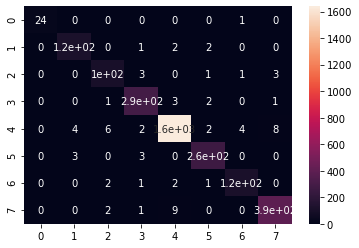

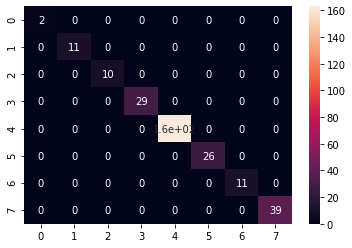

In [19]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.96 0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.96 0.   0.01 0.02 0.02 0.   0.  ]
 [0.   0.   0.93 0.03 0.   0.01 0.01 0.03]
 [0.   0.   0.   0.98 0.01 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.98 0.   0.   0.  ]
 [0.   0.01 0.   0.01 0.   0.98 0.   0.  ]
 [0.   0.   0.02 0.01 0.02 0.01 0.95 0.  ]
 [0.   0.   0.   0.   0.02 0.   0.   0.97]]


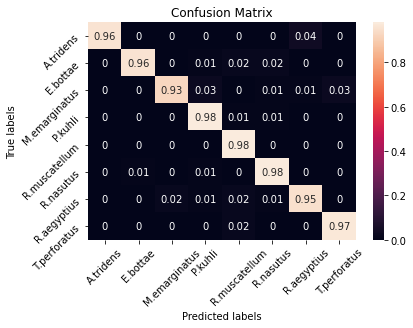

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);